# Tutorial 9: Learning the Inverse Design Map ‚Äì *from $\hat{H}$ to Geometry*

In this tutorial, we explore how to infer device geometry from Hamiltonian parameters by learning the inverse design map. We introduce a custom machine learning architecture tailored to capture the underlying physics of this mapping. Specifically, we aim to answer:

1) Which design space parameters most significantly influence a given set of Hamiltonian parameters?
2) How does each Hamiltonian parameter quantitatively depend on these key design variables?


**Note: This tutorial was originally created for the [Quantum Device Workshop](https://qdw-ucla.squarespace.com/), and includes some optional "tasks" for workshop participants. Feel free to skip these if you're just interested in the main content.**

### Environment Setup Recommendation

**We strongly recommend creating a separate Python environment for this notebook to ensure all dependencies are installed and to avoid conflicts with your base environment.**

Please follow the setup instructions here:  
https://github.com/LFL-Lab/QDW2025/blob/main/notebooks/advance-track/setup_instructions.md

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Our Model:

We propose a two-model architecture to understand the physics of the Hamiltonian-Design space mapping. 

1. **Design-Relevance Encoder**
   The first stage is a lightweight model (e.g., Random Forest or Lasso) that **identifies the subset of geometric design parameters most relevant** to each Hamiltonian parameter. This compresses the full design space into a minimal, interpretable feature subset for each target Hamiltonian.

2. **KAN-based Symbolic Decoder**
    The second model, a **Kolmogorov‚ÄìArnold Network (KAN)** is trained to **symbolically model the Hamiltonian parameter** as a function of only its relevant design variables. The KAN outputs a closed-form symbolic expression, enabling direct interpretation of the underlying physics-driven dependency.

## Design-Relevance Encoder

The **Design-Relevance Encoder** identifies which geometric parameters $\boldsymbol{\xi}$ most influence each target Hamiltonian parameter $\hat{\mathcal{H}}$. To do this, we train an interpretable model ‚Äî **Lasso regression**  ‚Äî to predict each Hamiltonian component from the full set of geometric inputs.

* **Lasso (Least Absolute Shrinkage and Selection Operator)** selects relevant features via coefficient shrinkage, automatically zeroing out irrelevant ones.

By using this model's outputs we construct a relevance mask that tells us which subset of design parameters significantly affect each $\hat{\mathcal{H}}$. This subset is then used as input to symbolic regression (e.g. KAN) to extract compact, human-readable expressions.


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import json
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree
import torch
import sympy as sp
import matplotlib.pyplot as plt
import random

Let's use the training dataset we generated in [Tutorial 7](https://lfl-lab.github.io/SQuADDS/source/tutorials/Tutorial-8_ML_interpolation_in_SQuADDS.html)

In [3]:
training_df = pd.read_parquet("data/training_data.parquet")

In [4]:
hamiltonian_parameters = ['qubit_frequency_GHz', 'anharmonicity_MHz', 'cavity_frequency_GHz', 'kappa_kHz', 'g_MHz']
design_parameters = ['cross_length', 'claw_length','coupling_length', 'total_length','ground_spacing']

In [5]:
Y_hamiltonian = training_df[hamiltonian_parameters].values # Hamiltonian parameters
X_design = training_df[design_parameters].values # Design parameters

The following object implemets the `LASSO` model to serve as the Design-Relevance Encoder

In [6]:
class DesignRelevanceEncoder:
    def __init__(self, X_design, Y_hamiltonian, design_labels, hamiltonian_labels):
        """
        Initialize the analyzer with design inputs and Hamiltonian outputs.
        """
        self.X_raw = X_design
        self.Y_raw = Y_hamiltonian
        self.design_labels = design_labels
        self.hamiltonian_labels = hamiltonian_labels

        self.scaler_X = StandardScaler()
        self.scaler_Y = StandardScaler()

        self.X = self.scaler_X.fit_transform(self.X_raw)
        self.Y = self.scaler_Y.fit_transform(self.Y_raw)

    def run_random_forest(self, n_estimators=200, random_state=42):
        """
        Trains a random forest for each Hamiltonian parameter.
        Stores and returns a feature importance DataFrame.
        """
        importance_matrix = np.zeros((self.X.shape[1], self.Y.shape[1]))

        for i, h_name in enumerate(self.hamiltonian_labels):
            rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
            rf.fit(self.X, self.Y[:, i])
            importance_matrix[:, i] = rf.feature_importances_

        self.rf_importance_df = pd.DataFrame(importance_matrix,
                                             index=self.design_labels,
                                             columns=self.hamiltonian_labels)
        return self.rf_importance_df

    def run_multitask_lasso(self, alpha_grid=np.logspace(-4, 1, 20)):
        """
        Trains a multi-task Lasso model.
        Stores and returns the coefficient matrix as DataFrame.
        """
        model = MultiTaskLassoCV(alphas=alpha_grid, cv=5, random_state=42)
        model.fit(self.X, self.Y)
        coef_matrix = model.coef_.T  # (n_design, n_hamiltonian)

        self.lasso_coef_df = pd.DataFrame(coef_matrix,
                                          index=self.design_labels,
                                          columns=self.hamiltonian_labels)
        return self.lasso_coef_df

    def plot_heatmaps(self):
        """
        Plots side-by-side heatmaps of RF and Lasso results.
        """
        fig, axs = plt.subplots(1, 2, figsize=(16, 6))

        sns.heatmap(self.rf_importance_df,
                    annot=True, cmap="YlOrRd", ax=axs[0], cbar_kws={'label': 'Feature Importance'})
        axs[0].set_title("Random Forest: Design Parameter Importance")
        axs[0].set_xlabel("Hamiltonian Parameter")
        axs[0].set_ylabel("Design Parameter")

        sns.heatmap(self.lasso_coef_df,
                    annot=True, center=0, cmap="coolwarm", ax=axs[1], cbar_kws={'label': 'Coefficient Value'})
        axs[1].set_title("Multi-Task Lasso: Design Influence")
        axs[1].set_xlabel("Hamiltonian Parameter")
        axs[1].set_ylabel("Design Parameter")

        plt.tight_layout()
        plt.show()

    def print_dependency_summary(self, top_k=3, threshold=1e-3):
        """
        Prints top-k most important design variables per Hamiltonian parameter
        from both Random Forest and Lasso results.
        """
        print("\n=== Top Influencers from Random Forest ===")
        for h in self.hamiltonian_labels:
            top = self.rf_importance_df[h].sort_values(ascending=False)
            print(f"\n- {h}:")
            for i in range(top_k):
                print(f"    ‚Ä¢ {top.index[i]} ‚Üí importance = {top.values[i]:.4f}")

        print("\n=== Top Influencers from Lasso (with direction) ===")
        for h in self.hamiltonian_labels:
            top = self.lasso_coef_df[h].abs().sort_values(ascending=False)
            print(f"\n- {h}:")
            for i in range(top_k):
                param = top.index[i]
                coef = self.lasso_coef_df[h][param]
                print(f"    ‚Ä¢ {param} ‚Üí coef = {coef:.4f} ({'‚Üë' if coef > 0 else '‚Üì'})")

    def plot_heatmap(self):
        """
        Plots a single heatmap depending on which model was run.
        If both are run, plots both side by side.
        If only one is run, plots only that one.
        """
        has_rf = hasattr(self, 'rf_importance_df')
        has_lasso = hasattr(self, 'lasso_coef_df')

        if has_rf and has_lasso:
            self.plot_heatmaps()
        elif has_rf:
            plt.figure(figsize=(8, 6))
            sns.heatmap(self.rf_importance_df, annot=True, cmap="YlOrRd", cbar_kws={'label': 'Feature Importance'})
            plt.title("Random Forest: Design Parameter Importance")
            plt.xlabel("Hamiltonian Parameter")
            plt.ylabel("Design Parameter")
            plt.tight_layout()
            plt.show()
        elif has_lasso:
            plt.figure(figsize=(8, 6))
            sns.heatmap(self.lasso_coef_df, annot=True, center=0, cmap="coolwarm", cbar_kws={'label': 'Coefficient Value'})
            plt.title("Multi-Task Lasso: Design Influence")
            plt.xlabel("Hamiltonian Parameter")
            plt.ylabel("Design Parameter")
            plt.tight_layout()
            plt.show()
        else:
            raise ValueError("Neither Random Forest nor Lasso results are available. Run one of the analysis methods first.")

    def get_dependency_summary_json(self, top_k=3, threshold=1e-3, pretty_print=True):
        """
        Returns a JSON-like dict of top design parameters (and their scores) for each Hamiltonian parameter.
        Only includes parameters with absolute score above the threshold.
        If both models are run, returns both. Otherwise, returns only the available one.
        If pretty_print is True, also prints the summary in a human-readable format.
        """
        summary = {}
        if hasattr(self, 'rf_importance_df'):
            rf_summary = {}
            for h in self.hamiltonian_labels:
                top = self.rf_importance_df[h].sort_values(ascending=False)
                filtered = [
                    {"parameter": top.index[i], "importance": float(top.values[i])}
                    for i in range(len(top))
                    if abs(top.values[i]) >= threshold
                ][:top_k]
                rf_summary[h] = filtered
            summary['random_forest'] = rf_summary
        if hasattr(self, 'lasso_coef_df'):
            lasso_summary = {}
            for h in self.hamiltonian_labels:
                top = self.lasso_coef_df[h].abs().sort_values(ascending=False)
                filtered = [
                    {
                        "parameter": top.index[i],
                        "coef": float(self.lasso_coef_df[h][top.index[i]])
                    }
                    for i in range(len(top))
                    if abs(top.values[i]) >= threshold
                ][:top_k]
                lasso_summary[h] = filtered
            summary['lasso'] = lasso_summary

        if pretty_print:
            print("\n=== Dependency Summary (Top {} per Hamiltonian parameter, threshold={}) ===".format(top_k, threshold))
            print(json.dumps(summary, indent=4))

        return summary


In [7]:
ml_analyzer = DesignRelevanceEncoder(
    X_design, 
    Y_hamiltonian, 
    design_labels=design_parameters,
    hamiltonian_labels=hamiltonian_parameters
)


In [8]:
ml_analyzer.run_multitask_lasso()

qubit_frequency_GHz  anharmonicity_MHz  cavity_frequency_GHz  \
cross_length               -0.956645           0.904895              0.000207   
claw_length                -0.005958           0.007807             -0.220192   
coupling_length            -0.000277           0.000236             -0.153045   
total_length                0.000482          -0.000646             -0.924025   
ground_spacing             -0.001715           0.002270              0.000009   

                 kappa_kHz     g_MHz  
cross_length      0.000060 -0.574872  
claw_length      -0.141799  0.932547  
coupling_length   0.877849 -0.073914  
total_length     -0.484510 -0.394851  
ground_spacing    0.000282 -0.350630

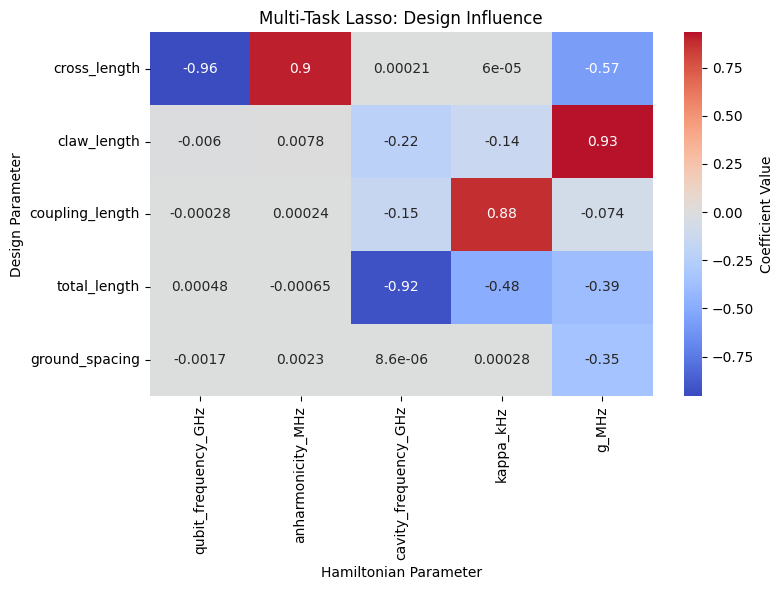

In [9]:
ml_analyzer.plot_heatmap()

In [10]:
dependency_summary = ml_analyzer.get_dependency_summary_json(top_k=2, threshold=0.1)


=== Dependency Summary (Top 2 per Hamiltonian parameter, threshold=0.1) ===
{
    "lasso": {
        "qubit_frequency_GHz": [
            {
                "parameter": "cross_length",
                "coef": -0.9566450702946909
            }
        ],
        "anharmonicity_MHz": [
            {
                "parameter": "cross_length",
                "coef": 0.9048951896956229
            }
        ],
        "cavity_frequency_GHz": [
            {
                "parameter": "total_length",
                "coef": -0.9240245095002161
            },
            {
                "parameter": "claw_length",
                "coef": -0.22019159774679983
            }
        ],
        "kappa_kHz": [
            {
                "parameter": "coupling_length",
                "coef": 0.8778486103719524
            },
            {
                "parameter": "total_length",
                "coef": -0.48451014050957547
            }
        ],
        "g_MHz": [
            {
  

## KAN Decoder

The KAN (Kolmogorov‚ÄìArnold Network) decoder learns a compact symbolic expression for a Hamiltonian parameter based on a subset of relevant geometric features. Unlike traditional neural networks, KAN explicitly fits interpretable functional forms using trainable basis functions, revealing the underlying physics in closed-form expressions. After training, the network can be pruned and symbolic expressions extracted using a user-defined library of functions, yielding formulas that capture how design geometry affect the Hamiltonian parameters

### Example: Selecting Features and Target for KAN

In this example flow, we demonstrate how to set up the KAN model for inverse design. 
First, we select the Hamiltonian parameter to model‚Äîin this case, the cavity frequency $f_{cav}$ (in GHz).
Next, using the results from the Design-Relevance Encoder, we identify **`total_length`** and **`claw_length`** as the two most influential design parameters for predicting `cavity_frequency`.

We then proceed to extract and process the relevant features from the training dataset to prepare for model training.

In [11]:
target_feature = 'cavity_frequency_GHz'

In [12]:
input_features = [i["parameter"] for i in dependency_summary["lasso"][target_feature]]
input_features

['total_length', 'claw_length']

In [13]:
X = training_df[input_features].values
y = training_df[target_feature].values.reshape(-1, 1)

# Split into train/val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)


# Convert to PyTorch tensors
train_input = torch.tensor(X_train, dtype=torch.float32)
test_input = torch.tensor(X_val, dtype=torch.float32)
train_label = torch.tensor(y_train, dtype=torch.float32)
test_label = torch.tensor(y_val, dtype=torch.float32)

# Final dataset dict for pykan
dataset = {
    "train_input": train_input,
    "test_input": test_input,
    "train_label": train_label,
    "test_label": test_label
}


### KAN Model Setup

We now define and initialize the Kolmogorov‚ÄìArnold Network (KAN) model to learn a symbolic expression for the Hamiltonian parameter $f_{cav}$. The chosen architecture `KAN(width=[2, 2, 1], grid=5, k=3)` reflects:

* **Input layer** with 2 neurons for the two most relevant geometric features: `total_length` and `claw_length`.
* **One hidden layer** with 2 units, each equipped with a set of grid-based basis functions.
* **Output layer** producing a single scalar value corresponding to `cavity_frequency_GHz`.

The `grid` parameter sets how many grid points each neuron's nonlinear activation uses: increasing `grid` allows the model to capture more complex, detailed functions, but may reduce smoothness and interpretability; decreasing it makes the model simpler and smoother, but less expressive. The `k` parameter controls local smoothing by determining how many nearby grid points influence each output: higher `k` values produce smoother, more robust functions, while lower `k` values allow for sharper, more localized changes in the learned function.


Setting random seed to 0 to ensure reproducibility ü§ûüèΩ

In [15]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [16]:
from kan import *

checkpoint directory created: ./model
saving model version 0.0


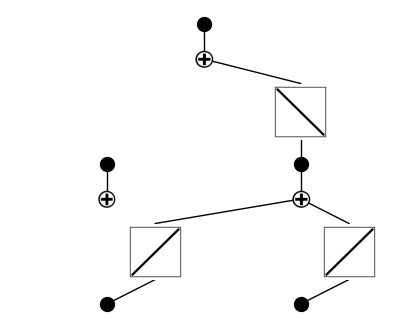

In [17]:
model = KAN(width=[2,2,1], grid=5, k=3)
model(dataset['train_input']);
model.plot(beta=100)

This plot shows the untrained KAN model for predicting cavity frequency from `total_length` and `claw_length`. Each black dot represents an input, which is passed through learnable univariate function blocks (squares) that apply symbolic transformations (e.g., `x`, `x¬≤`, `sin`). These transformed features are summed (white ‚Äú+‚Äù nodes) to build the output. At this stage, all functions are uninitialized (linear ramps), and the structure reflects the model's capacity to discover symbolic patterns through training.

### Encouraging Symbolic Simplicity

Before training, we configure two key regularization terms that guide the KAN model toward interpretable symbolic solutions:

* **`lamb` (L2 sparsity penalty):** This term encourages the weights of the model to be small, reducing model complexity. A higher value forces the network to use fewer basis functions and promotes sparsity in the learned representation.

* **`lamb_entropy` (functional entropy penalty):** This term penalizes overly complex or chaotic nonlinear transformations by minimizing the entropy of the learned functional basis. It nudges the network to favor smooth, low-entropy functions like polynomials, sinusoids, or exponentials.

Together, these regularizers bias the training process toward compact, human-readable formulas instead of overfitted black-box predictions.

In [18]:
metrics = model.fit(dataset, steps=100, lamb=0.01, lamb_entropy=10)

| train_loss: 3.28e-01 | test_loss: 3.30e-01 | reg: 5.57e+00 | : 100%|‚ñà| 100/100 [02:39<00:00,  1.60

saving model version 0.1


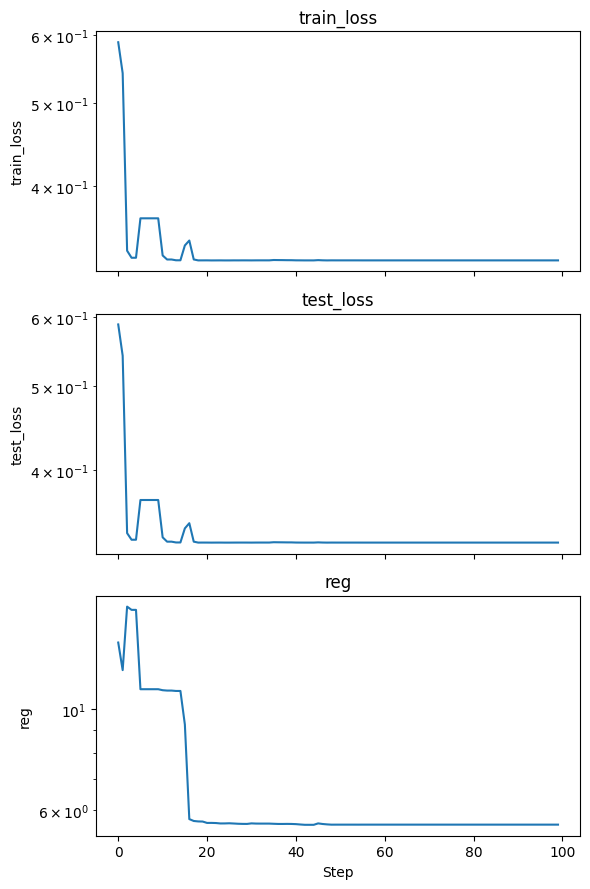

In [19]:
fig, axs = plt.subplots(len(metrics), 1, figsize=(6, 3 * len(metrics)), sharex=True)
if len(metrics) == 1:
    axs = [axs]
for i, key in enumerate(metrics.keys()):
    axs[i].plot(metrics[key])
    axs[i].set_yscale('log')
    axs[i].set_title(key)
    axs[i].set_ylabel(key)
axs[-1].set_xlabel('Step')
plt.tight_layout()
plt.show()

Lets visualize the trained KAN model.

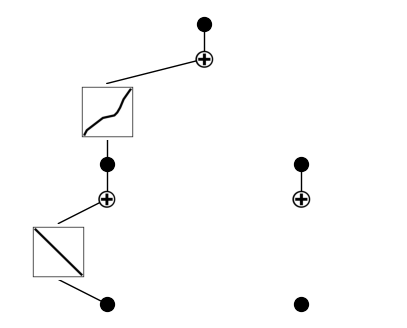

In [20]:
model.plot()

After training, the model has learned to rely primarily on the total meander length input, passing it through two distinct nonlinear transformations before summing their outputs to predict the target. The claw length input remains disconnected, indicating it was not found to be predictive by the network during optimization.

As a best practice, we prune the model at this stage to remove redundant or low-contribution paths. This step simplifies the learned symbolic equation, making it more interpretable by eliminating unnecessary neurons and connections that do not significantly impact the prediction. Pruning refines the model architecture before further fine-tuning.

saving model version 0.2


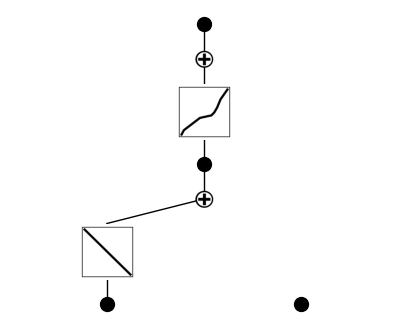

In [21]:
model = model.prune()
model(dataset['train_input'])
model.plot()


The updated architecture clearly shows that the model now relies on distinct nonlinear transformations of both inputs (total meander length and claw length), though one transformation from claw length is weak and de-emphasized.

We retrain after pruning to slightly adjust the remaining functions for better accuracy.

| train_loss: 3.27e-01 | test_loss: 3.30e-01 | reg: 1.66e+00 | : 100%|‚ñà| 50/50 [00:39<00:00,  1.27it


saving model version 0.3


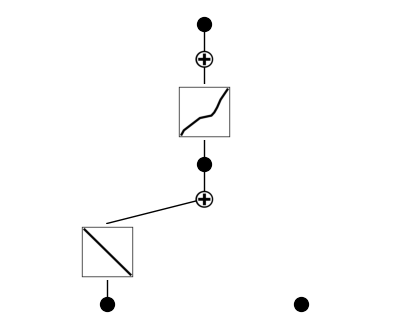

In [22]:
model.fit(dataset, steps=50)
try:
    model.plot()
except Exception as e:
    print("Error plotting model")


Finally, we define a library of candidate symbolic functions (polynomials, sinusoids, logs, etc.). KAN fits the learned internal structure to combinations of these and then extracts the final symbolic formula representing:

$$
{f_{cav}} = f(\text{cross\_length}, \text{claw\_length})
$$


In [23]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model.auto_symbolic(lib=lib)

fixing (0,0,0) with x, r2=1.0000005960464478, c=1
fixing (0,1,0) with 0
fixing (1,0,0) with x, r2=0.9552730917930603, c=1
saving model version 0.4


In [95]:
model.symbolic_formula()

([-0.00169442449984271*x_1 - 5.35003944827876e-12*x_2 - 5.43009030583892e-6*sin(9.40023994445801*x_2 - 9.61199951171875) + 13.2851943596568],
 [x_1, x_2])

Lets visually interpret the symbolic model and compare it to the data.

In [24]:
def plot_symbolic_surface(f_sym, x1_range, x2_range, x1_label, x2_label, z_label, title, cmap='plasma'):
    """
    Plots a 2D surface of a symbolic model f_sym(x1, x2) over the specified ranges.
    """
    X2, X1 = np.meshgrid(x2_range, x1_range)
    Z = f_sym(X1, X2)
    plt.figure(figsize=(6, 6))
    c = plt.pcolormesh(x2_range, x1_range, Z, shading='auto', cmap=cmap)
    plt.xlabel(x2_label, fontsize=12)
    plt.ylabel(x1_label, fontsize=12)
    cbar = plt.colorbar(c, label=z_label)
    cbar.ax.tick_params(labelsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title(title, fontsize=13)
    plt.tight_layout()
    plt.show()

def plot_symbolic_vs_data(f_sym, x1_vals, fixed_x2, real_X, real_y, x1_col, x2_col, tol, x1_label, x2_label, y_label, title):
    """
    Plots the symbolic model prediction vs. real data for a fixed x2 value.
    """
    f_pred = f_sym(x1_vals, fixed_x2)
    mask = np.abs(real_X[:, x2_col] - fixed_x2) < tol
    x1_real = real_X[mask, x1_col]
    y_real = real_y[mask]
    plt.figure(figsize=(8, 6))
    plt.plot(x1_vals, f_pred, label=f'Symbolic Model (fixed {x2_label}={fixed_x2})', color='C0')
    plt.scatter(x1_real, y_real, color='C1', edgecolor='k', s=40,
                label=f'Real Data (fixed {x2_label}={fixed_x2}¬±{tol})')
    plt.xlabel(x1_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()

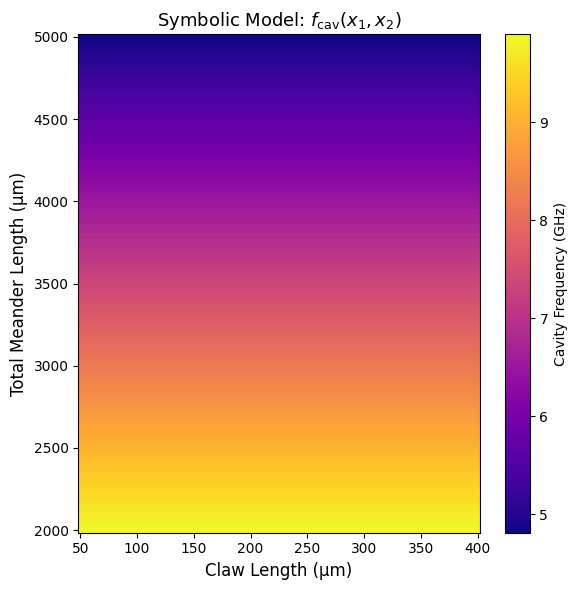

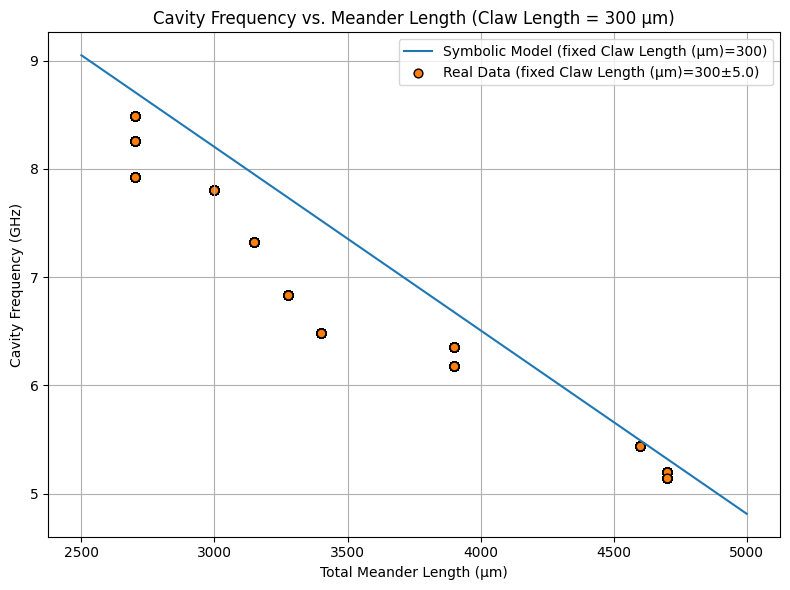

In [25]:
# Define symbolic model
x1, x2 = sp.symbols('x_1 x_2')
expr = (-0.00169442449984271*x1 - 5.35003944827876e-12*x2 - 5.43009030583892e-6*sin(9.40023994445801*x2 - 9.61199951171875) + 13.2851943596568)
f_sym = sp.lambdify((x1, x2), expr, modules='numpy')

# 1. Surface plot
claw_vals = np.linspace(50, 400, 100)       # x2: claw length [¬µm]
meander_vals = np.linspace(2000, 5000, 100) # x1: total meander length [¬µm]
plot_symbolic_surface(
    f_sym,
    x1_range=meander_vals,
    x2_range=claw_vals,
    x1_label='Total Meander Length (¬µm)',
    x2_label='Claw Length (¬µm)',
    z_label='Cavity Frequency (GHz)',
    title=r'Symbolic Model: $f_{\mathrm{cav}}(x_1, x_2)$'
)

# 2. Symbolic vs. data plot
fixed_claw = 300
x1_vals = np.linspace(2500, 5000, 200)
input_features = ['total_length', 'claw_length']
target_feature = 'cavity_frequency_GHz'
X = training_df[input_features].values
y = training_df[target_feature].values.reshape(-1)
tol = 5.0  # microns

# x1_col=0 (total_length), x2_col=1 (claw_length)
plot_symbolic_vs_data(
    f_sym,
    x1_vals=x1_vals,
    fixed_x2=fixed_claw,
    real_X=X,
    real_y=y,
    x1_col=0,
    x2_col=1,
    tol=tol,
    x1_label='Total Meander Length (¬µm)',
    x2_label='Claw Length (¬µm)', 
    y_label='Cavity Frequency (GHz)',
    title=f'Cavity Frequency vs. Meander Length (Claw Length = {fixed_claw} ¬µm)'
)

The symbolic expression returned by the KAN model is:

$$
f_{cav}(x_1, x_2) = a_1 x_1 + a_2 x_2 + a_3 \sin(b_1 x_2 + b_2) + a_4
$$

with the following numerical values:

* $a_1 = -1.694 \times 10^{-3}$
* $a_2 = -5.35 \times 10^{-12}$
* $a_3 = -5.43 \times 10^{-6}$
* $b_1 = 9.40$, $b_2 = -9.61$
* $a_4 = 13.285$

### Dimensional Analysis and Simplification

In our dataset:

* $x_1 \in [2000, 5000] \, \mu\text{m}$
* $x_2 \in [100, 400] \, \mu\text{m}$

We can estimate the magnitude of each term:

* $a_1 x_1 \sim - 3.5$ ‚Äî dominant term
* $a_2 x_2 \sim 10^{-9}$ ‚Äî negligible
* $a_3 \sin(\cdot) \sim 10^{-6}$ ‚Äî negligible
* $a_4 \sim 13.3$ ‚Äî dominant constant offset

Thus, to leading order, the model simplifies to:

$$
f_{cav}(x_1, x_2) \approx a_1 x_1 + a_4
$$


### Interpretation
 
In summary, the model shows that total meander length $x_1$ is the dominant factor affecting cavity frequency, with other terms (including those involving claw length $x_2$) being negligible. This matches physical expectations and demonstrates that the symbolic formula found by KAN is both accurate and interpretable, serving as a reliable and efficient surrogate for more complex simulations.

**Note:** KAN model outcomes are probabilistic‚Äîif you do not set a deterministic random seed, you may not obtain the exact same symbolic model or results each time you run this notebook. Additionally, the hyperparameters used here are not fully optimized; further tuning will certainly yield improved performance and interpretability at the cost of training time.

---


## Task 1: Symbolic Discovery with KANs Using Design-Relevance Insights

Your goal is to explore **symbolic relationships between Hamiltonian parameters and the most relevant design variables** using a KAN model

Start by choosing a Hamiltonian parameter of interest (e.g., $g$, $\alpha_q$) and use the **design-relevance encoder** outputs to identify which geometry parameters matter most for that target.

Then:

* Use those selected design variables as inputs to the KAN model.
* Train KAN to **learn an interpretable symbolic mapping** from geometry to the Hamiltonian parameter.

Try different architectures, libraries of functions, and pruning thresholds to extract concise and meaningful symbolic expressions. The goal is to gain **physical insight** into how specific design features influence device behavior ‚Äî not just predict, but understand.

If your symbolic model makes sense and teaches us something cool, shoot us an [email](mailto:shanto@usc.edu).

In [41]:
# ------------------------------
# Helpful to fix the random seed
# ------------------------------
SEED =5212025
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# your code here

## Task 2: 

I had a similar-ish model (no hyperparameter tuning) for that predicted the following for the coupling strength, $g$:

$$
g(x_1, x_2) = 1.2306 \cdot x_1 + 0.6623 \cdot x_2 - 848.14 \cdot \sqrt{0.00559 \cdot x_1 + 0.00134 \cdot x_2 + 1} + 1016.44
$$

Writing it without the constants:

$$
g(x_1, x_2) = a_1 x_1 + a_2 x_2 - b \cdot \sqrt{c_1 x_1 + c_2 x_2 + 1} + d
$$

Where:
- $x_1$: cross length (in microns)  
- $x_2$: claw length (in microns)  
- $a_1, a_2$: linear gain coefficients  
- $b$: scale of nonlinear saturation  
- $c_1, c_2$: coupling weightings inside the square root  
- $d$: baseline offset  

It seems to have fitted our data very well. 

<div style="display: flex; justify-content: space-between; margin: 20px 0;">
    <div style="flex: 1; margin: 0 10px;">
        <h3>Reference plot from the SQuADDS paper</h3>
        <img src="paper-plot.png" alt="Plot 1" style="width: 100%;">
    </div>
    <div style="flex: 1; margin: 0 10px;">
        <h3>Comparision plot to the SQuADDS paper from the model</h3>
        <img src="g_plot.png" alt="Plot 2" style="width: 100%;">
    </div>
    <div style="flex: 1; margin: 0 10px;">
        <h3>Model prediction</h3>
        <img src="g_pred.png" alt="Plot 3" style="width: 100%;">
    </div>
</div>

Discuss amongst yourselves to see if this expression is physically meaningful or not. 

## License

<div style='width: 100%; background-color:#3cb1c2;color:#324344;padding-left: 10px; padding-bottom: 10px; padding-right: 10px; padding-top: 5px'>
    <h3>This code is a part of SQuADDS</h3>
    <p>Developed by Sadman Ahmed Shanto</p>
    <p>This tutorial is written by Sadman Ahmed Shanto</p> 
    <p>&copy; Copyright Sadman Ahmed Shanto & Eli Levenson-Falk 2025.</p>
    <p>This code is licensed under the MIT License. You may<br> obtain a copy of this license in the LICENSE.txt file in the root directory<br> of this source tree.</p>
    <p>Any modifications or derivative works of this code must retain this<br>copyright notice, and modified files need to carry a notice indicating<br>that they have been altered from the originals.</p>
</div>